In [1]:
!pip install transformers --quiet
import json
import math
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertModel, BertConfig, get_linear_schedule_with_warmup, pipeline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.9 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
myDrive_path = '/content/gdrive/My Drive/'
dir_path = os.path.join(myDrive_path, 'Intent_Analysis_Final_Project', 'intent-analysis-bert')

Mounted at /content/gdrive


In [3]:
import random 
data_name = "en-US.jsonl"
data_path = os.path.join(dir_path, data_name)
data = []
with open(data_path, 'r') as f:
    for line in f:
      data.append(json.loads(line))

In [20]:
from collections import defaultdict
intent_stats = defaultdict(int)
scenario_stats = defaultdict(int)
max_len = defaultdict(int)
for entry in data:
    intent = entry['intent']
    scenario = entry['scenario']
    max_len[len(entry['utt'])] += 1
    intent_stats[intent] +=1
    scenario_stats[scenario] +=1

In [ ]:
print(max_len)

defaultdict(<class 'int'>, {31: 469, 35: 412, 5: 27, 10: 101, 4: 36, 26: 485, 21: 388, 19: 348, 36: 456, 44: 294, 13: 150, 18: 293, 27: 471, 34: 432, 39: 321, 28: 471, 33: 455, 29: 516, 14: 190, 16: 262, 65: 61, 25: 435, 45: 252, 42: 280, 49: 214, 41: 296, 9: 87, 38: 419, 43: 271, 54: 146, 48: 203, 24: 469, 22: 416, 23: 439, 17: 283, 20: 358, 30: 477, 32: 475, 40: 341, 15: 243, 11: 134, 7: 41, 37: 391, 52: 146, 51: 180, 59: 105, 64: 73, 56: 111, 53: 150, 6: 41, 47: 241, 50: 205, 60: 93, 55: 144, 12: 163, 58: 94, 57: 137, 46: 242, 68: 59, 69: 42, 76: 30, 71: 42, 2: 4, 74: 27, 82: 23, 62: 74, 73: 28, 78: 19, 63: 75, 75: 29, 3: 6, 79: 25, 70: 44, 80: 17, 72: 28, 77: 33, 61: 73, 67: 54, 8: 71, 95: 7, 85: 16, 98: 6, 99: 8, 94: 6, 66: 45, 89: 9, 88: 10, 84: 14, 112: 2, 87: 10, 83: 18, 92: 8, 86: 13, 108: 6, 91: 9, 109: 4, 101: 2, 100: 5, 103: 6, 81: 10, 143: 1, 97: 6, 130: 1, 132: 1, 114: 3, 96: 5, 105: 4, 107: 7, 127: 2, 119: 4, 124: 1, 106: 2, 90: 8, 145: 2, 117: 1, 102: 3, 189: 1, 135: 2,

In [4]:
unique_intents = sorted(list(set([entry['intent'] for entry in data])))
unique_scenarios = sorted(list(set([entry['scenario'] for entry in data])))
print(unique_intents)
print(unique_scenarios)
print(f"Number of unique intents: {len(unique_intents)}")
print(f"Number of unique scenarios: {len(unique_scenarios)}")

['alarm_query', 'alarm_remove', 'alarm_set', 'audio_volume_down', 'audio_volume_mute', 'audio_volume_other', 'audio_volume_up', 'calendar_query', 'calendar_remove', 'calendar_set', 'cooking_query', 'cooking_recipe', 'datetime_convert', 'datetime_query', 'email_addcontact', 'email_query', 'email_querycontact', 'email_sendemail', 'general_greet', 'general_joke', 'general_quirky', 'iot_cleaning', 'iot_coffee', 'iot_hue_lightchange', 'iot_hue_lightdim', 'iot_hue_lightoff', 'iot_hue_lighton', 'iot_hue_lightup', 'iot_wemo_off', 'iot_wemo_on', 'lists_createoradd', 'lists_query', 'lists_remove', 'music_dislikeness', 'music_likeness', 'music_query', 'music_settings', 'news_query', 'play_audiobook', 'play_game', 'play_music', 'play_podcasts', 'play_radio', 'qa_currency', 'qa_definition', 'qa_factoid', 'qa_maths', 'qa_stock', 'recommendation_events', 'recommendation_locations', 'recommendation_movies', 'social_post', 'social_query', 'takeaway_order', 'takeaway_query', 'transport_query', 'transpor

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
intent_weight = []
scenario_weight = []
for intent in unique_intents:
    intent_weight.append(1 - intent_stats[intent]/len(data))
for scenario in unique_scenarios:
    scenario_weight.append(1 - scenario_stats[scenario]/len(data))
intent_weight = torch.tensor(intent_weight, device=device)
scenario_weight = torch.tensor(scenario_weight, device=device)

In [22]:
class IntentDataset(Dataset):
    def __init__(self, data, unique_intents, unique_scenarios, tokenizer, partition='dev'):
        self.data = data
        self.current_dataset = [entry for entry in self.data if entry['partition'] == partition]
        self.intents = [entry["intent"] for entry in self.current_dataset]
        self.scenarios = [entry["scenario"] for entry in self.current_dataset]
        self.unique_intents = unique_intents
        self.unique_scenarios = unique_scenarios
        self.tokenizer = tokenizer
        self.intent_to_id = {intent: i for i, intent in enumerate(self.unique_intents)}
        self.id_to_intent = {i: intent for intent, i in self.intent_to_id.items()}
        self.scenario_to_id = {scenario: i for i, scenario in enumerate(self.unique_scenarios)}
        self.id_to_scenario = {i: scenario for scenario, i in self.scenario_to_id.items()}
        self.intent_labels = [self.intent_to_id[intent] for intent in self.intents]
        self.scenario_labels =[self.scenario_to_id[scenario] for scenario in self.scenarios] 
        self.input_data = [entry['utt'] for entry in self.current_dataset]
        self.encodings = self.tokenizer(self.input_data, return_tensors='pt', padding="max_length",max_length=128, truncation=True)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['scenario_label'] = torch.tensor(self.scenario_labels[idx])
        item['intent_label'] = torch.tensor(self.intent_labels[idx])
        return item

    def __len__(self):
        return len(self.input_data)

In [8]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, config, intent_num, scenario_num):
        super().__init__()
        self.bert = BertModel(config)
        self.intent_cls = nn.Linear(98304, intent_num)
        self.scenario_cls = nn.Linear(98304, scenario_num)
        
        self.intent_num = intent_num
        self.scenario_num = scenario_num
        
    def forward(self, input_ids, attention_mask=None, past_key_values=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0]
        intent_logits = self.intent_cls(pooled_output.flatten(start_dim=1))
        scenario_logits = self.scenario_cls(pooled_output.flatten(start_dim=1))
        return intent_logits, scenario_logits 

In [6]:
model_engine = "bert-base-uncased"
tokenizer = tokenizer = AutoTokenizer.from_pretrained(model_engine)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [25]:
batch_size = 16
trainset = IntentDataset(data, unique_intents, unique_scenarios, tokenizer, partition='train')
valset = IntentDataset(data, unique_intents,unique_scenarios, tokenizer)
trainLoader = DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
valLoader = DataLoader(valset, batch_size, shuffle=False, num_workers=2)

In [9]:
config = BertConfig.from_pretrained(model_engine)
model = BertForSequenceClassification(config, len(unique_intents), len(unique_scenarios))
model.bert.resize_token_embeddings(len(tokenizer))
model = model.to(device)

In [ ]:
epochs = 15

# Optimizer
optimal_lr = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=optimal_lr, weight_decay=0.01)

# Scheduler
total_steps = len(trainLoader) * epochs
warmup_ratio = 0.05
warmup_steps = int(warmup_ratio * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

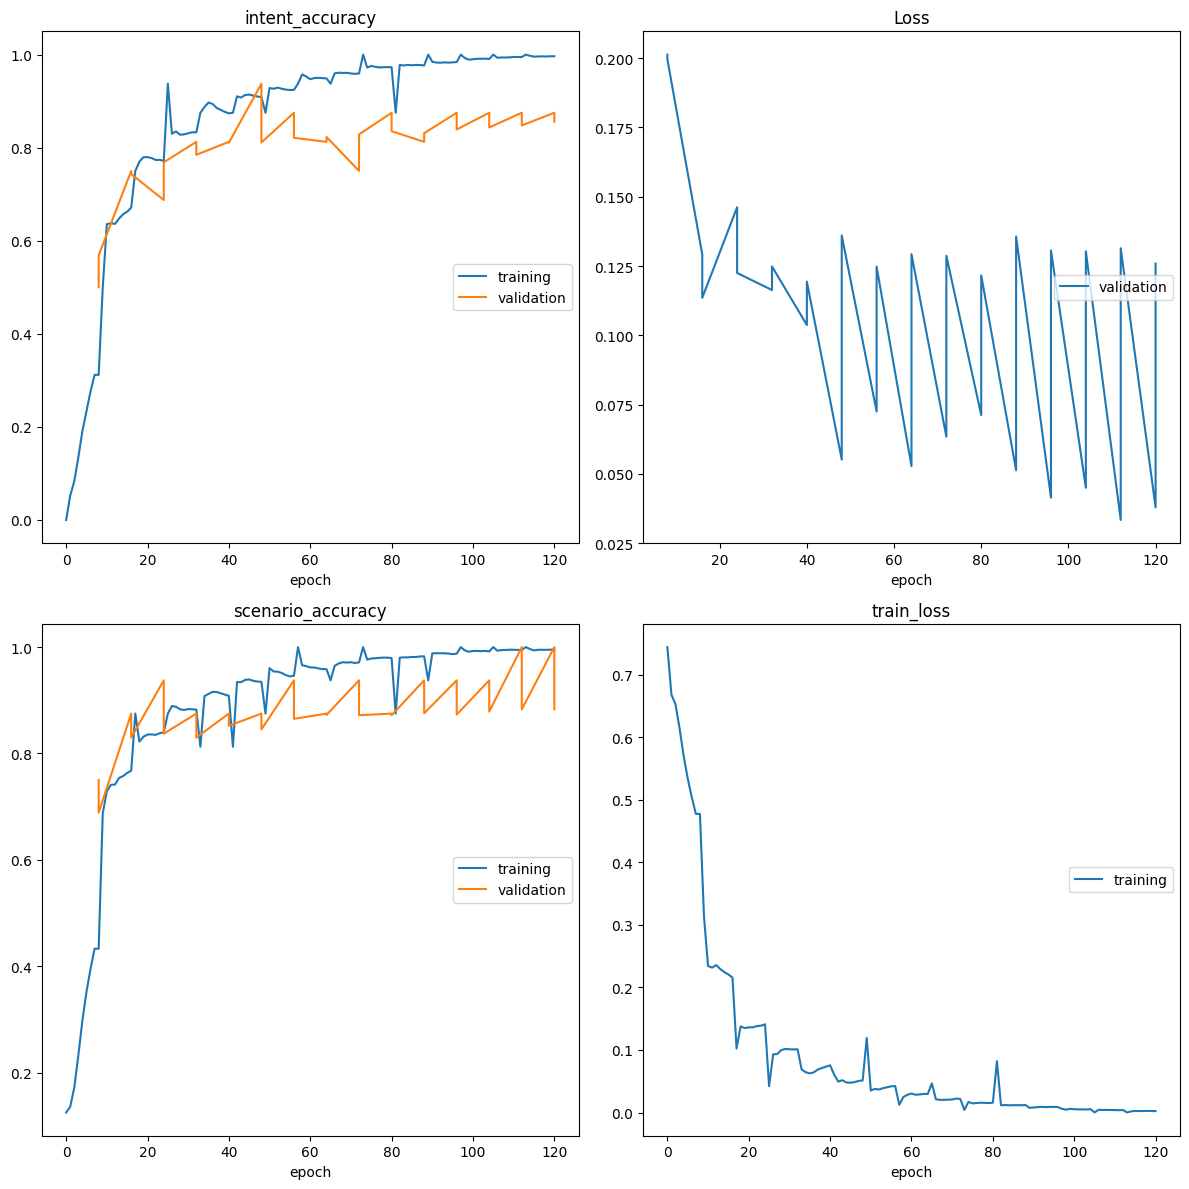

intent_accuracy
	training         	 (min:    0.000, max:    1.000, cur:    0.997)
	validation       	 (min:    0.500, max:    0.938, cur:    0.856)
Loss
	validation       	 (min:    0.033, max:    0.201, cur:    0.126)
scenario_accuracy
	training         	 (min:    0.125, max:    1.000, cur:    0.995)
	validation       	 (min:    0.689, max:    1.000, cur:    0.883)
train_loss
	training         	 (min:    0.000, max:    0.744, cur:    0.002)


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
max_acc = 0
liveloss = PlotLosses()
current_step = 0
intent_ce = nn.CrossEntropyLoss(weight=intent_weight)
scenario_ce = nn.CrossEntropyLoss(weight=scenario_weight)
past_key_values = None

for epoch in range(epochs):
    logs = {}
    cumulative_loss = 0
    intent_cumulative_accuracy = 0
    scenario_cumulative_accuracy = 0
    num_samples = 0

    model.train()
    # print("In training loop...")
    for id, batch in enumerate(trainLoader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        intent_labels = batch['intent_label'].to(device)
        scenario_labels = batch['scenario_label'].to(device)
        intent_logits, scenario_logits  = model(input_ids, attention_mask=attention_mask)
        model.zero_grad()
        intent_loss = intent_ce(intent_logits, intent_labels)
        scenario_loss = scenario_ce(scenario_logits, scenario_labels)
        losses = 2 * intent_loss + scenario_loss
        losses.backward()
        optimizer.step()
        scheduler.step()

        cumulative_loss += losses.item()
        intent_preds = torch.argmax(intent_logits, dim=1)
        scenario_preds = torch.argmax(scenario_logits, dim=1)
        intent_cumulative_accuracy += (intent_preds == intent_labels).sum().item()
        scenario_cumulative_accuracy += (scenario_preds == scenario_labels).sum().item()
        num_samples += input_ids.size(0)

        if id % 100 == 0:
            avg_train_loss = cumulative_loss / num_samples
            avg_train_intent_accuracy = intent_cumulative_accuracy / num_samples
            avg_train_scenario_accuracy = scenario_cumulative_accuracy / num_samples
            # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_train_accuracy}, Loss: {avg_train_loss}")
            logs['train_loss'] = avg_train_loss
            logs['intent_accuracy'] = avg_train_intent_accuracy
            logs['scenario_accuracy'] = avg_train_scenario_accuracy
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    model.eval()
    cumulative_loss = 0
    intent_cumulative_accuracy = 0
    scenario_cumulative_accuracy = 0
    num_samples = 0
    # print("In validation loop...")
    with torch.no_grad():
        for id, batch in enumerate(valLoader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intent_labels = batch['intent_label'].to(device)
            scenario_labels = batch['scenario_label'].to(device)
            intent_logits, scenario_logits = model(input_ids, attention_mask=attention_mask)
            model.zero_grad()
            intent_loss = intent_ce(intent_logits, intent_labels)
            scenario_loss = scenario_ce(scenario_logits, scenario_labels)
            losses = intent_loss + scenario_loss
            cumulative_loss += losses.item()
            intent_preds = torch.argmax(intent_logits, dim=1)
            scenario_preds = torch.argmax(scenario_logits, dim=1)
            intent_cumulative_accuracy += (intent_preds == intent_labels).sum().item()
            scenario_cumulative_accuracy += (scenario_preds == scenario_labels).sum().item()
            num_samples += input_ids.size(0)


            if id % 100 == 0:
                avg_val_loss = cumulative_loss / num_samples
                avg_val_intent_accuracy = intent_cumulative_accuracy / num_samples
                if avg_val_intent_accuracy > max_acc:
                    max_acc = avg_val_intent_accuracy
                    model_name = f"bert-intent-analysis-{max_acc}.pth"
                    model_path = os.path.join(dir_path, model_name)
                    for f in os.listdir(dir_path):
                        if f.endswith('.pth'):
                            os.remove(f)
                    torch.save(model.state_dict(), model_path)
                avg_val_scenario_accuracy = scenario_cumulative_accuracy / num_samples
              # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_train_accuracy}, Loss: {avg_train_loss}")
                logs['val_loss'] = avg_val_loss
                logs['val_intent_accuracy'] = avg_val_intent_accuracy
                logs['val_scenario_accuracy'] = avg_val_scenario_accuracy
                liveloss.update(logs, current_step)
                liveloss.send()


In [ ]:
torch.save(model.state_dict(), model_path)

In [10]:
# model_name = "bert-intent-analysis"

# Load best model
for f in os.listdir(dir_path):
    if f.endswith('.pth'):
        print(f"Model: {f}")
model_path = os.path.join(dir_path, 'bert-intent-analysis-0.9375.pth')
model.load_state_dict(torch.load(model_path))

Model: bert-intent-analysis-0.9375.pth
Model: bert-intent-analysis-0.5625.pth
Model: bert-intent-analysis-0.568069306930693.pth
Model: bert-intent-analysis-0.625.pth
Model: bert-intent-analysis-0.7103960396039604.pth
Model: bert-intent-analysis-0.8125.pth
Model: bert-intent-analysis-0.8131188118811881.pth
Model: bert-intent-analysis-0.8168316831683168.pth
Model: bert-intent-analysis-0.8279702970297029.pth
Model: bert-intent-analysis-0.8316831683168316.pth
Model: bert-intent-analysis-0.8353960396039604.pth
Model: bert-intent-analysis-0.8378712871287128.pth
Model: bert-intent-analysis-0.8391089108910891.pth
Model: bert-intent-analysis-0.8403465346534653.pth


<All keys matched successfully>

In [40]:
def predict_intent(inputs, model=model):
    model.eval()
    input_ids = inputs['input_ids'].unsqueeze(0).to(device)
    attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
    with torch.no_grad():
        outputs, _ = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    return preds.item()

In [41]:
testset = IntentDataset(data, unique_intents, unique_scenarios, tokenizer, partition='test')
testLoader = DataLoader(testset, batch_size, shuffle=False, num_workers=2)
index = 20
data_item = testset[index]
input_dat = testset.input_data[20]

# Extract input_ids, attention_mask, and label from the data_item
input_ids = data_item['input_ids']
attention_mask = data_item['attention_mask']
label = data_item['intent_label']

# Print the original text and label by decoding the input_ids
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(f"Text: {decoded_text}")
print(f"True label id: {label.item()}")
print(f"True label: {testset.id_to_intent[label.item()]}")

label_idx = predict_intent(data_item)
print(f"Pred label id: {label_idx}")
print(f"Pred label: {testset.id_to_intent[label_idx]}")


Text: what's this week's weather
True label id: 59
True label: weather_query
Pred label id: 59
Pred label: weather_query


In [ ]:
correct = 0
for i in range(len(testset)):
    data_item = testset[i]

    # Extract input_ids, attention_mask, and label from the data_item
    input_ids = data_item['input_ids']
    attention_mask = data_item['attention_mask']
    label = data_item['intent_label']
    label_idx = predict_intent(data_item)
    if label_idx == label.item():
        correct += 1
print(f"Test Accuracy: {round(correct / len(testset)*100, 3)}%")

Test Accuracy: 83.759%


In [ ]:
# Set the model to evaluation mode
model.eval()

# Define the lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation set and make predictions
for batch in testLoader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['intent_label'].to(device)
    with torch.no_grad():
        outputs, _ = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

In [ ]:
def compute_metrics(true_labels, predicted_labels, unique_classes):
    precision, recall = 0, 0
    true_positives, false_positives, false_negatives = 0, 0, 0
    for cls in range(len(unique_classes)):
        for tl, pl in zip(true_labels, predicted_labels):
            if tl == cls and pl == cls:
                true_positives += 1
            elif tl != cls and pl == cls:
                false_positives += 1
            elif tl == cls and pl != cls:
                false_negatives += 1

        precision += true_positives / (true_positives + false_positives + 1e-12)
        recall += true_positives / (true_positives + false_negatives + 1e-12)

    precision /= len(unique_classes)
    recall /= len(unique_classes)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-12)

    return precision, recall, f1

precision, recall, f1 = compute_metrics(true_labels, predicted_labels, unique_intents)
print(f"Avg Precision: {precision:.4f}\n\
Avg Recall: {recall:.4f}\n\
Avg F1: {f1:.4f}\n\
Total samples: {len(testset)}")

Avg Precision: 0.8610
Avg Recall: 0.8552
Avg F1: 0.8581
Total samples: 2974
